## Positive WAF — `PyTorch` implementation

Let's imagine hypothetically the website with the following REST API:
* `GET/website/itmes/?id={ID}`
* `POST/website/script.js/?time={TIME}`
* `GET/api/?token={TOKEN}`

Where 
* `ID` is number from 0 to 1000
* `TIME` is a Unix timestamp from 13/09/2020 to 03/03/2021
* `TOKEN` is a lowercase hex string

The task is to build the model which can "learn" the structure of the aforecited requests and alert when the inupt request is not correspond to such structure or even conatins threats

### 1. Generate synthetic data

In [1]:
import uuid
import torch
import string
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
_ = torch.manual_seed(0)

In [2]:
def gen_get():
    return f'GET/website/itmes/?id={np.random.randint(1000, size=1)[0]}'
            
def gen_post():
    return f'POST/website/script.js/?time={np.random.randint(1600000000, 1620000000, size=1)[0]}'

def gen_api():
     return f'GET/api/?token={uuid.uuid4().hex}'

We will use `N` sample in total with the equal probabilty of each API call

In [3]:
N = 10000

In [4]:
data = []
for i in range(N):
    t = i%3
    if t==0:
        data.append(gen_get())
    elif t==1:
        data.append(gen_api())
    else:
        data.append(gen_post())

In [5]:
data[:10]

['GET/website/itmes/?id=684',
 'GET/api/?token=048789e1cd514184880be9be91a0f3a2',
 'POST/website/script.js/?time=1618261621',
 'GET/website/itmes/?id=192',
 'GET/api/?token=da1fe4ac0433465d887f21b40b9cd75e',
 'POST/website/script.js/?time=1605157699',
 'GET/website/itmes/?id=763',
 'GET/api/?token=b62b47a2b86044919c39be2922697971',
 'POST/website/script.js/?time=1615039847',
 'GET/website/itmes/?id=9']

### 2. Data preprocessing 

#### 2.1 Build vocabulary

In [6]:
unique_tokens = np.unique(list(map(list, ''.join(data))))

In [7]:
unique_tokens

array(['.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=',
       '?', 'E', 'G', 'O', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f',
       'i', 'j', 'k', 'm', 'n', 'o', 'p', 'r', 's', 't', 'w'], dtype='<U1')

In [8]:
start_token = '<sos>'
end_token = '<eos>'
pad_token = '<pad>'
unk_token = '<unk>'

def build_vocab(unique_tokens):
    d={}
    d[start_token] = 0
    d[end_token] = 1
    d[pad_token] = 2
    d[unk_token] = 3
    
    for i, c in enumerate(unique_tokens):
        d.update({c: i+4})
        
    return d

In [9]:
vocab = build_vocab(unique_tokens)
inv_vocab = {value:key for key, value in vocab.items()}

#### 2.2 Tokenize data

In [10]:
start_token = inv_vocab[0]
end_token = inv_vocab[1]
pad_token = inv_vocab[2]
unk_token = inv_vocab[3]

def pad_seq(seq, maxlen):
    return [start_token] + list(seq) + [end_token] + [pad_token for _ in range(maxlen-len(seq))]

def tokenize_seq(seq):
    return [vocab[i] if i in vocab else vocab[unk_token] for i in seq]

def untokenize_seq(seq):
    return [inv_vocab[i] for i in seq]

#### 2.3 Split into train/validation/test sets

In [12]:
# 60/20/20

train_txt, val_txt, test_txt = np.split(data, [int(.6*len(data)), int(.8*len(data))])

print(f'Training on   : {train_txt.shape[0]} samples')
print(f'Validating on : {val_txt.shape[0]} samples')
print(f'Testing on    : {test_txt.shape[0]} samples')

Training on   : 6000 samples
Validating on : 2000 samples
Testing on    : 2000 samples


In [13]:
def prepare_batch(batch_txt):
    """ pad -> tokenize -> convert BATCH to tensor"""
    batch_maxlen = max(list(map(len, batch_txt)))
    
    padded_batch = [pad_seq(x, batch_maxlen) for x in batch_txt]
    tokenized_batch = [tokenize_seq(x) for x in padded_batch]
    
    return torch.tensor(tokenized_batch)

### 3. Create model

We would define 2 models
1. Reccurent text autoencoder
2. Autoencder based on transformer model

In [14]:
import math
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoder(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [15]:
class TransofrmerAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_layers, dropout, pad_idx, n_head, d_ff):
        
        super(TransofrmerAutoencoder, self).__init__()
        
        self.emb_enc = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.emb_dec = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.pos_enc = PositionalEncoder(d_model=embed_dim, dropout=dropout)
        
        self.transformer = nn.Transformer(d_model=embed_dim,
                                          nhead=n_head,
                                          num_encoder_layers=n_layers,
                                          num_decoder_layers=n_layers,
                                          dim_feedforward=d_ff)
        
        self.logit = nn.Linear(embed_dim, vocab_size)
        
        
    def forward(self, X):
        emb_enc = self.emb_enc(X)
        emb_dec = self.emb_dec(X)
        
        pos_enc = self.pos_enc(emb_enc)
        pos_dec = self.pos_enc(emb_dec)
        
        trans_outpt = self.transformer(pos_enc, pos_dec)
        
        return self.logit(trans_outpt)

In [16]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, gru_units, n_layers, dropout, pad_idx):
        
        super(RecurrentAutoencoder, self).__init__()
        
        self.emb_enc = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru_enc = nn.GRU(input_size=embed_dim, hidden_size=gru_units, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        self.emb_dec = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru_dec = nn.GRU(input_size=embed_dim, hidden_size=gru_units, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        self.logit = nn.Linear(embed_dim, vocab_size)
        
        
    def forward(self, X, h0=None):
        enc_inpt = self.emb_enc(X)
        dec_inpt = self.emb_dec(X)
        
        _, hid_enc = self.gru_enc(enc_inpt, h0)
        dec_outpt, _ = self.gru_dec(dec_inpt, hid_enc)
        
        return self.logit(dec_outpt)

In [32]:
model = TransofrmerAutoencoder(vocab_size=len(vocab.keys()), embed_dim=32, n_layers=1, dropout=.2, pad_idx=vocab[pad_token], n_head=4, d_ff=128)
#model = RecurrentAutoencoder(vocab_size=len(vocab.keys()), embed_dim=32, gru_units=32, n_layers=6, pad_idx=vocab[pad_token], dropout=.25)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab[pad_token])
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

### 4. Train

In [34]:
def train_on_batch(X_batch):
    # Reset grad
    optimizer.zero_grad()

    # Forward pass
    X_pred = model(X_batch)

    # Compute loss & backward pass
    loss = criterion(X_pred.transpose(0,1).transpose(1,2), X_batch.transpose(0,1))
    loss.backward()

    # Prevent gradient explosion.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    # Step optimizer
    optimizer.step()

    # Return batch loss
    return loss.detach().item()   

In [35]:
batch_size = 64
n_epochs = 10

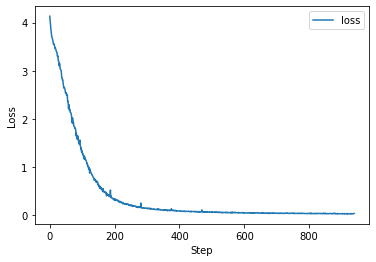

Epoch 9 loss - 0.025069 lr - 0.000599 time spent - 2.954 seconds
Trainig complete


In [36]:
import time
from tqdm.notebook import tqdm
from IPython.display import clear_output

loss_history = []
print(f'Start trainig on {n_epochs} epochs with batch size {batch_size}')

# Shuffle training data
X_train = train_txt
np.random.shuffle(X_train) 

for epoch in range(n_epochs):  
    model.zero_grad()
    epoch_start = time.time()
    epoch_loss = []
    
    for i, start_index in enumerate(tqdm(range(0, len(X_train), batch_size))):
        batch_data = X_train[start_index:start_index+batch_size]
        X_batch = prepare_batch(batch_data)
        step_loss = train_on_batch(X_batch)
        epoch_loss.append(step_loss)
        
    scheduler.step()
    loss_history.extend(epoch_loss)
    
    # Visualize training process
    clear_output(True)
    plt.plot(loss_history, label='loss')
    plt.xlabel('Step')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    print(f'Epoch {epoch} loss - {np.mean(epoch_loss):.6f} lr - {scheduler.get_last_lr()[0]:.6f} time spent - {time.time()-epoch_start:.3f} seconds')

print('Trainig complete')

## 5. Validate & pick a deciaion threshold

In [37]:
model.eval()
val_batch_size = 12

X_val = val_txt.copy()
np.random.shuffle(X_val)
with torch.no_grad():
    val_loss = []
    print(f'Validating on {len(X_val)} samples with batch size {val_batch_size}')
    for i in tqdm(range(0, len(X_val), val_batch_size)):
        batch_data = X_val[i:i+val_batch_size]
        X_batch = prepare_batch(batch_data)
        X_pred = model(X_batch)
        loss = criterion(X_pred.transpose(0,1).transpose(1,2), X_batch.transpose(0,1))
        val_loss.append(loss.item())
    
    print(f'Validating complete. Val loss: {np.mean(val_loss)}')

Validating on 2000 samples with batch size 12



Validating complete. Val loss: 0.13597633560260614


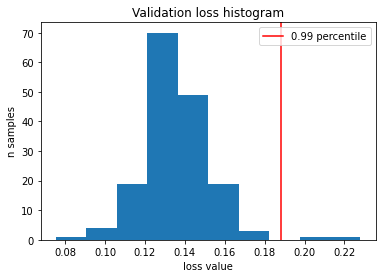

In [43]:
P_RATE = .99
p_value = np.quantile(val_loss, P_RATE)

plt.hist(val_loss)
plt.axvline(p_value, c='red', label=f'{P_RATE} percentile')

plt.title('Validation loss histogram')
plt.xlabel('loss value')
plt.ylabel('n samples')
plt.legend()
plt.show()

In [44]:
from IPython.display import HTML

threshod = p_value

HTML(f'<h2 style="color:red;"> Threshold: {np.round(threshod, 4)}</h1>')

## 6.Test

In [45]:
FP = []

with torch.no_grad():
    test_loss = []
    print(f'Testing on {len(test_txt)} samples')
    for i, x in enumerate(tqdm((test_txt))):
        actual = prepare_batch([x])
        predicted = model(actual)
        
        loss = criterion(predicted.transpose(0,1).transpose(1,2), actual.transpose(0,1)).item()

        if loss > threshod:
            FP.append(i)
        
    print(f'Testing complete. Test loss: {np.round(np.mean(val_loss), 3)}')

Testing on 2000 samples



Testing complete. Test loss: 0.136


In [46]:
print(f"Number of False positives: {len(FP)} out of {len(test_txt)} or {round(len(FP)/len(test_txt)*100, 2)}%")

Number of False positives: 2000 out of 2000 or 100.0%


In [48]:
if len(FP) > 10:
    print_fp = 10
else:
    print_fp = len(FP)
    
for i in range(print_fp):
    print(''.join(test_txt[FP[i]]), '\n')

POST/website/script.js/?time=1606359136 

GET/website/itmes/?id=92 

GET/api/?token=1adf44e274394cd4bec257ae87a6d646 

POST/website/script.js/?time=1614269176 

GET/website/itmes/?id=586 

GET/api/?token=0051585a07854949a997f08349ccbe7f 

POST/website/script.js/?time=1614465379 

GET/website/itmes/?id=285 

GET/api/?token=a7db2054ae4444b5a6c1b9e491cb77f4 

POST/website/script.js/?time=1613014205 



## 7. Visualize

In [49]:
from colorama import Fore

def visual(inpt, outpt, threshold):
    """
    Color the most 'badly' parts of request
    Args:
        inpt:      <torch.tensor>
        outpt:     <torch.tensor>
        threshold: <float> 0-1
    Returns:
        Colored input string
    """
    coefs = np.array([[outpt[j, i, inpt[j, i]].item() for i in range(inpt.shape[1])] for j in range(inpt.shape[0])])
    min_ = np.amin(coefs, axis=1)[np.newaxis].T
    max_ = np.amax(coefs, axis=1)[np.newaxis].T
    probs = (coefs - min_) / (max_ - min_)
    
    visual_text = []
    for i in range(probs.shape[0]):
        text = ''
        for j in range(probs.shape[1]):
            if inv_vocab[inpt[i, j].item()] == pad_token:
                break
            if probs[i, j] < threshold:
                c = Fore.GREEN
            else:
                c = Fore.BLACK
            text += ''.join(c + inv_vocab[inpt[i, j].item()])
        visual_text.append(text)
        
    return visual_text

In [50]:
def process_str_visual(s, temp=0.1):
    """s - string"""
    s_prep = pad_seq(s, len(s))
    s_tok = tokenize_seq(s_prep)
    inpt_tensor = torch.tensor(s_tok).view(1, -1)
    
    pred_tensor = model(inpt_tensor)
    loss = criterion(pred_tensor.transpose(0,1).transpose(1,2), inpt_tensor.transpose(0,1)).item()
    outpt_tensor = F.softmax(pred_tensor, dim=2)
    
    colored_str = visual(inpt_tensor, outpt_tensor, temp)[0]

    res_str = f"{colored_str}\n"

    ratio = loss/threshod
    if ratio < 1:
        res_str += (Fore.GREEN + f"ratio: {ratio:.5f}")
    else:
        res_str += (Fore.RED + f"ratio: {ratio:.5f}")
        
    res_str += f"\nloss {loss}"
    
    return f"{res_str}\n\n"

In [51]:
import random
from ipywidgets import interactive,FloatSlider


s_attacks = [
    'GET/login.php',
    'GET/website/api/?token=%27%3B+DROP+TABLE+customers',
    'GET/suggestions/api/4_1/rs/iplocate/fio?ip=<script>alert()</script>'
]

s_broken = [
    'GET/api/?token=HFLKHSLHFKLJFKJLH',
    'GET/website/itmes/?id=-1',
    'GET/website/itmes/?id=9999999999',
    'POST/website/script.js/?time=22210777731'
]

s_good = random.sample(test_txt.tolist(),5)

def foo(temperature, dataset):
        print(''.join(process_str_visual(x, temperature) for x in dataset))

interactive(foo, 
            temperature=FloatSlider(min=0, max=1, step=0.01, value=0.9),
            dataset={"attacks":s_attacks, "test":s_good, "broken": s_broken}
          )

interactive(children=(FloatSlider(value=0.9, description='temperature', max=1.0, step=0.01), Dropdown(descript…

## 7. Time measuring

In [80]:
def forward_pass(s, model, criterion):
    '''Passes string <s> through <model> and returns computed loss value'''
    s_prep = pad_seq(s, len(s))
    s_tok = tokenize_seq(s_prep)
    inpt_tensor = torch.tensor(s_tok).view(1, -1)

    pred_tensor = model(inpt_tensor)
    return criterion(pred_tensor.transpose(0,1).transpose(1,2), inpt_tensor.transpose(0,1)).item()

In [81]:
s = random.choice(test_txt)
print(f'Sample text: {s},\nSample len: {len(s)}\n')

Sample text: GET/website/itmes/?id=568,
Sample len: 25



### 7.1 Python

__Disable autograd__

In [82]:
with torch.no_grad():
    %time _ = forward_pass(s, model, criterion)

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 5.08 ms


__Enable autograd__

In [83]:
%time _ = forward_pass(s, model, criterion)

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 5.67 ms


### 7.2 Quantization

In [84]:
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Bilinear}, dtype=torch.qint8 ) 

In [85]:
%time _ = forward_pass(s, quantized_model, criterion)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 5.33 ms
